In [1]:
import gym
import numpy as np
import matplotlib.pyplot as plt
import random
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision.transforms as T
from collections import defaultdict
from tqdm import tqdm
from copy import deepcopy

In [2]:
N_ROWS, N_COLS, N_WIN = 3, 3, 3

class TicTacToe(gym.Env):
    def __init__(self, n_rows=N_ROWS, n_cols=N_COLS, n_win=N_WIN, clone=None):
        if clone is not None:
            self.n_rows, self.n_cols, self.n_win = clone.n_rows, clone.n_cols, clone.n_win
            self.board = copy.deepcopy(clone.board)
            self.curTurn = clone.curTurn
            self.emptySpaces = None
            self.boardHash = None
        else:
            self.n_rows = n_rows
            self.n_cols = n_cols
            self.n_win = n_win
            self.reset()

    def getEmptySpaces(self):
        if self.emptySpaces is None:
            res = np.where(self.board == 0)
            self.emptySpaces = np.array([ (i, j) for i,j in zip(res[0], res[1]) ])
        return self.emptySpaces

    def makeMove(self, player, i, j):
        self.board[i, j] = player
        self.emptySpaces = None
        self.boardHash = None

    def getHash(self):
        if self.boardHash is None:
            self.boardHash = ''.join(['%s' % (x+1) for x in self.board.reshape(self.n_rows * self.n_cols)])
        return self.boardHash

    def isTerminal(self):
        # проверим, не закончилась ли игра
        cur_marks, cur_p = np.where(self.board == self.curTurn), self.curTurn
        for i,j in zip(cur_marks[0], cur_marks[1]):
            win = False
            if i <= self.n_rows - self.n_win:
                if np.all(self.board[i:i+self.n_win, j] == cur_p):
                    win = True
            if not win:
                if j <= self.n_cols - self.n_win:
                    if np.all(self.board[i,j:j+self.n_win] == cur_p):
                        win = True
            if not win:
                if i <= self.n_rows - self.n_win and j <= self.n_cols - self.n_win:
                    if np.all(np.array([ self.board[i+k,j+k] == cur_p for k in range(self.n_win) ])):
                        win = True
            if not win:
                if i <= self.n_rows - self.n_win and j >= self.n_win-1:
                    if np.all(np.array([ self.board[i+k,j-k] == cur_p for k in range(self.n_win) ])):
                        win = True
            if win:
                self.gameOver = True
                return self.curTurn

        if len(self.getEmptySpaces()) == 0:
            self.gameOver = True
            return 0

        self.gameOver = False
        return None

    def printBoard(self):
        for i in range(0, self.n_rows):
            print('----'*(self.n_cols)+'-')
            out = '| '
            for j in range(0, self.n_cols):
                if self.board[i, j] == 1:
                    token = 'x'
                if self.board[i, j] == -1:
                    token = 'o'
                if self.board[i, j] == 0:
                    token = ' '
                out += token + ' | '
            print(out)
        print('----'*(self.n_cols)+'-')

    def getState(self):
        return (self.getHash(), self.getEmptySpaces(), self.curTurn)

    def action_from_int(self, action_int):
        return ( int(action_int / self.n_cols), int(action_int % self.n_cols))

    def int_from_action(self, action):
        return action[0] * self.n_cols + action[1]
    
    def step(self, action):
        if self.board[action[0], action[1]] != 0:
            return self.getState(), -10, True, {}
        self.makeMove(self.curTurn, action[0], action[1])
        reward = self.isTerminal()
        self.curTurn = -self.curTurn
        return self.getState(), 0 if reward is None else reward, reward is not None, {}

    def reset(self):
        self.board = np.zeros((self.n_rows, self.n_cols), dtype=int)
        self.boardHash = None
        self.gameOver = False
        self.emptySpaces = None
        self.curTurn = 1
        return self.getState()

def plot_board(env, pi, showtext=True, verbose=True, fontq=20, fontx=60):
    '''Рисуем доску с оценками из стратегии pi'''
    fig, ax = plt.subplots(1, 1, figsize=(10, 10))
    X, Y = np.meshgrid(np.arange(0, env.n_rows), np.arange(0, env.n_rows))
    Z = np.zeros((env.n_rows, env.n_cols)) + .01
    s, actions = env.getHash(), env.getEmptySpaces()
    if pi is not None and s in pi.Q:
        for i, a in enumerate(actions):
            Z[a[0], a[1]] = pi.Q[s][i]
    ax.set_xticks([])
    ax.set_yticks([])
    surf = ax.imshow(Z, cmap=plt.get_cmap('Accent', 10), vmin=-1, vmax=1)
    if showtext:
        for i,a in enumerate(actions):
            if pi is not None and s in pi.Q:
                ax.text( a[1] , a[0] , "%.3f" % pi.Q[s][i], fontsize=fontq, horizontalalignment='center', verticalalignment='center', color="w" )
    for i in range(env.n_rows):
        for j in range(env.n_cols):
            if env.board[i, j] == -1:
                ax.text(j, i, "O", fontsize=fontx, horizontalalignment='center', verticalalignment='center', color="w" )
            if env.board[i, j] == 1:
                ax.text(j, i, "X", fontsize=fontx, horizontalalignment='center', verticalalignment='center', color="w" )
    ax.grid(False)
    plt.show()

def get_and_print_move(env, pi, s, actions, random=False, verbose=True, fontq=20, fontx=60):
    '''Делаем ход, рисуем доску'''
    plot_board(env, pi, fontq=fontq, fontx=fontx)
    if verbose and (pi is not None):
        if s in pi.Q:
            for i,a in enumerate(actions):
                print(i, a, pi.Q[s][i])
        else:
            print("Стратегия не знает, что делать...")
    if random:
        return np.random.randint(len(actions))
    else:
        return pi.getActionGreedy(s, len(actions))

def plot_test_game(env, pi1, pi2, random_crosses=False, random_naughts=True, verbose=True, fontq=20, fontx=60):
    '''Играем тестовую партию между стратегиями или со случайными ходами, рисуем ход игры'''
    done = False
    env.reset()
    while not done:
        s, actions = env.getHash(), env.getEmptySpaces()
        if env.curTurn == 1:
            a = get_and_print_move(env, pi1, s, actions, random=random_crosses, verbose=verbose, fontq=fontq, fontx=fontx)
        else:
            a = get_and_print_move(env, pi2, s, actions, random=random_naughts, verbose=verbose, fontq=fontq, fontx=fontx)
        observation, reward, done, info = env.step(actions[a])
        if reward == 1:
            print("Крестики выиграли!")
            plot_board(env, None, showtext=False, fontq=fontq, fontx=fontx)
        if reward == -1:
            print("Нолики выиграли!")
            plot_board(env, None, showtext=False, fontq=fontq, fontx=fontx)

    1. Реализуйте обычное (табличное) Q-обучение. Обучите стратегии крестиков и ноликов для доски 3х3.
    2. Попробуйте обучить стратегии крестиков и ноликов для доски 4х4 и/или 5х5.

In [3]:
def play_episode(env, pi_x, pi_o):
    done = False
    env.reset()
    s, actions = env.getHash(), env.getEmptySpaces()
    while not done:
        if env.curTurn == 1:
            idx = pi_x.get_greedy_action(s, len(actions))
        else:
            idx = pi_o.get_greedy_action(s, len(actions))
        action = actions[idx]
        (s, actions, _), reward, done, info = env.step(action)
    return reward

def evaluate(env, pi_x, pi_o, n_plays):
    wins_x, wins_o = 0, 0
    for i in range(n_plays):
        reward = play_episode(env, pi_x, pi_o)
        if reward == 1:
            wins_x += 1
        elif reward == -1:
            wins_o += 1   
    return wins_x / n_plays, wins_o / n_plays

In [4]:
class TicTacToePolicy():
    def __init__(self):
        self.Q = defaultdict(lambda: defaultdict(float))
        
    def get_random_action(self, n_actions):
        return np.random.randint(n_actions)

    def get_greedy_action(self, s, n_actions):
        if (s in self.Q)  and (len(self.Q[s]) > 0):
            return max(self.Q[s], key=self.Q[s].get) 
        return self.get_random_action(n_actions)

    def get_max_score(self, s):
        if (s in self.Q) and (len(self.Q[s]) > 0):
            return max(self.Q[s].values())
        return 0
    
    
def Q_learning(env, pi_x, pi_o, alpha=0.05, epsilon=0.2, gamma=1.0):
    done = False
    env.reset()
    s, actions = env.getHash(), env.getEmptySpaces()
    s_o, idx_o = ' ', 0 
    while not done:
        if env.curTurn == 1:
            s_x = s
            idx_x = pi_x.get_greedy_action(s, len(actions)) if np.random.rand() > epsilon \
                      else pi_x.get_random_action(len(actions))
            action = actions[idx_x]
            (s, actions, _), reward, done, info = env.step(action) 
            pi_x.Q[s_x][idx_x] += alpha * (reward  - pi_x.Q[s_x][idx_x])
            pi_o.Q[s_o][idx_o] += alpha * gamma * pi_o.get_max_score(s) + alpha * (-reward)
        else:
            s_o = s
            idx_o = pi_o.get_greedy_action(s, len(actions)) if np.random.rand() > epsilon \
                      else pi_o.get_random_action(len(actions))
            action = actions[idx_o]        
            (s, actions, _), reward, done, info = env.step(action) 
            reward = -reward 
            pi_o.Q[s_o][idx_o] += alpha * (reward - pi_o.Q[s_o][idx_o])
            pi_x.Q[s_x][idx_x] += alpha * gamma * pi_x.get_max_score(s) + alpha * (-reward)


In [5]:
def evaluate_and_plot_wins(env, pi_x, pi_o, n_episodes=100000, n_episodes_eval=1000, step=1000):
    n_steps =  n_episodes // step 
    x = np.linspace(0, n_episodes, n_steps)
    wins_x, wins_o = [], []
    for i in tqdm(range(n_episodes)):
        Q_learning(env, pi_x, pi_o)
        if  i % step == 0:
            wins_x.append(evaluate(env, pi_x, TicTacToePolicy(), n_episodes_eval)[0])
            wins_o.append(evaluate(env, TicTacToePolicy(), pi_o, n_episodes_eval)[1])    
    plt.figure(figsize=(12, 8))
    plt.plot(x, wins_x, label='Победы крестиков')
    plt.plot(x, wins_o, color='g',label='Победы ноликов')
    plt.xlabel('Число эпизодов', fontsize=14)
    plt.ylabel('Победы', fontsize=14)
    plt.legend()
    plt.show();

100%|█████████████████████████████████| 200000/200000 [02:46<00:00, 1199.30it/s]


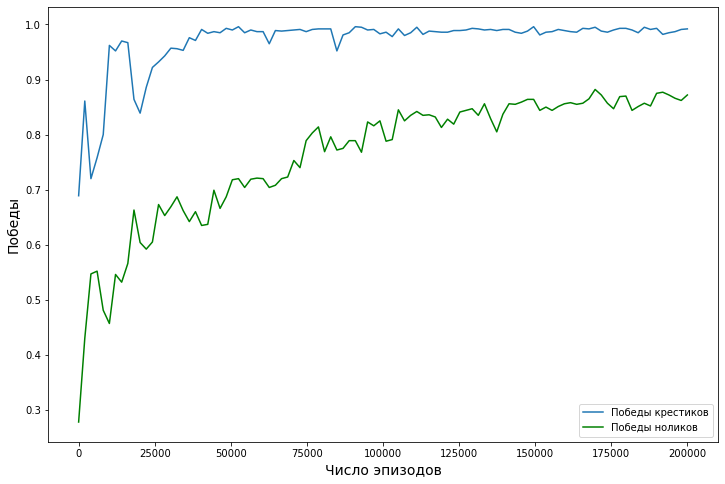

In [6]:
env_3 = TicTacToe(n_rows=3, n_cols=3, n_win=3)

pi_x = TicTacToePolicy()
pi_o = TicTacToePolicy()
evaluate_and_plot_wins(env_3, pi_x, pi_o,n_episodes=200000, n_episodes_eval=1000, step=2000)

100%|████████████████████████████████| 2000000/2000000 [46:12<00:00, 721.45it/s]


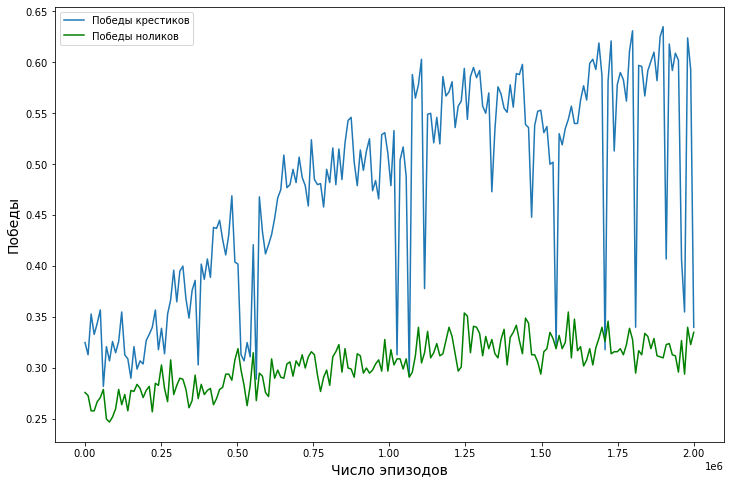

In [9]:
env_4 = TicTacToe(n_rows=4, n_cols=4, n_win=4)

pi_x = TicTacToePolicy()
pi_o = TicTacToePolicy()
evaluate_and_plot_wins(env_4, pi_x, pi_o, n_episodes=2_000_000, n_episodes_eval=1000, step=10000)

3. Реализуйте DQN с нейронной сетью, обучите стратегии крестиков и ноликов. Замечание: скорее всего, experience replay потребуется сразу же.

In [10]:
class ReplayMemory:
    def __init__(self, capacity):
        self.capacity = capacity
        self.memory = []
        self.position = 0

    def store(self, exptuple):
        if len(self.memory) < self.capacity:
            self.memory.append(None)
        self.memory[self.position] = exptuple
        self.position = (self.position + 1) % self.capacity
       
    def sample(self, batch_size):
        return random.sample(self.memory, batch_size)
    
    def __len__(self):
        return len(self.memory)
    
class Network_3(nn.Module):
    def __init__(self, layer_size=256):
        super().__init__()
        self.l1 = nn.Conv2d(3, layer_size, 3)
        self.l2 = nn.Linear(layer_size, layer_size)
        self.l3 = nn.Linear(layer_size, 9)

    def forward(self, x):
        x = F.relu(self.l1(x))
        x = torch.flatten(x, 1)
        x = F.relu(self.l2(x))
        x = self.l3(x)
        return x
    
class Network_4(nn.Module):
    def __init__(self, layer_size=256):
        super().__init__()
        self.l1 = nn.Conv2d(3, layer_size, 3)
        self.l2 = nn.Linear(layer_size * 4, layer_size)
        self.l3 = nn.Linear(layer_size, 16)

    def forward(self, x):
        x = F.relu(self.l1(x))
        x = torch.flatten(x, 1)
        x = F.relu(self.l2(x))
        x = self.l3(x)
        return x
      
class DQN:
    def __init__(self, env, network, batch_size=256, lr=1e-5, gamma=0.9, eps_init=0.8, eps_final=0.2, 
                 eps_decay=50000, weight_decay=1e-5):
        self.env = env
        self.model = { 1: network(),
                      -1: network()}
        self.memory = { 1: ReplayMemory(10000), 
                       -1: ReplayMemory(10000)}
        self.optimizer = { 1: optim.Adam(self.model[1].parameters(), lr, weight_decay=weight_decay), 
                          -1: optim.Adam(self.model[-1].parameters(), lr, weight_decay=weight_decay)}
        self.gamma = gamma
        self.batch_size = batch_size
        self.eps_init, self.eps_final, self.eps_decay = eps_init, eps_final, eps_decay
        self.num_step = 0

    def get_action_greedy(self, state, cur_turn):
        q = self.model[cur_turn](state.unsqueeze(0)).squeeze(0)
        return int(q.argmax())
       
    def get_actions_correct(self, empty_spaces):
        return np.array([self.env.int_from_action(a) for a in empty_spaces])

    def get_action(self, state, cur_turn, empty_spaces=None):
        sample = random.random()
        eps = self.eps_final + (self.eps_init - self.eps_final) * np.exp(-self.num_step / self.eps_decay)
        if sample > eps:
            return self.get_action_greedy(state, cur_turn)
        else:
            if empty_spaces is not None:
                legal_a_idx = self.get_actions_correct(empty_spaces)
                return np.random.choice(legal_a_idx)
            return np.random.randint(self.env.action_space)
        
    def board_to_tensor(self, board):
        board = np.array(list(map(np.int32, board))).reshape(self.env.n_rows, self.env.n_cols)
        board = np.stack([(board == 2).astype(np.int32),
                          (board == 0).astype(np.int32),
                          (board == 1).astype(np.int32)])
        return torch.FloatTensor(board)
        
    def run_episode(self, greedy=False):
        states = {1: [], -1: []}
        actions = {1: [], -1: []}
        s, empty_spaces, cur_turn = self.env.reset()
        done = False
        self.model[1].eval()
        self.model[-1].eval()
        while not done:
            with torch.no_grad():
                s_tensor = self.board_to_tensor(s)
                if greedy:
                    idx = self.get_action_greedy(s_tensor, cur_turn)
                else:
                    idx = self.get_action(s_tensor, cur_turn, empty_spaces)
                action = self.env.action_from_int(idx)
                next_state, r, done, _ = self.env.step(action)
                next_s, empty_spaces, next_turn = next_state
                next_s_tensor = self.board_to_tensor(next_s)
                if states[cur_turn]:
                    transition = (states[cur_turn][-1], actions[cur_turn][-1], s_tensor, torch.tensor([0], 
                                                                                    dtype=torch.float32))
                    self.memory[cur_turn].store(transition)
                if done:
                    break
                states[cur_turn].append(s_tensor)
                actions[cur_turn].append(torch.tensor([idx], dtype=torch.long))
                s = next_s
                cur_turn = next_turn                    
        if r == -10:
            transition = (s_tensor, torch.tensor([idx], dtype=torch.long), next_s_tensor, torch.tensor([r],
                                                                                        dtype=torch.float32))
            self.memory[cur_turn].store(transition) 
        else:
            transition = (s_tensor, torch.tensor([idx], dtype=torch.long), next_s_tensor, 
                                                           torch.tensor([cur_turn * r], dtype=torch.float32))
            self.memory[cur_turn].store(transition) 
            transition = (states[-cur_turn][-1], actions[-cur_turn][-1], next_s_tensor, 
                                                          torch.tensor([-cur_turn * r], dtype=torch.float32))
            self.memory[-cur_turn].store(transition) 
        self.num_step += 1
        self.learn(cur_turn)

    def learn(self, cur_turn):
        if len(self.memory[cur_turn]) < self.batch_size:
            return
        self.model[1].train()
        self.model[-1].train()
        transitions = self.memory[cur_turn].sample(self.batch_size)
        state, action, next_state, reward = zip(*transitions)
        state = torch.stack(state)
        action = torch.stack(action)
        reward = torch.cat(reward)
        next_state = torch.stack(next_state)
        Q = self.model[cur_turn](state).gather(1, action).reshape([self.batch_size])
        Q_max = self.model[cur_turn](next_state).detach().max(1)[0]
        Q_next = reward + (self.gamma * Q_max)
        loss = F.smooth_l1_loss(Q, Q_next)
        self.optimizer[cur_turn].zero_grad()
        loss.backward()
        self.optimizer[cur_turn].step()
        
    def evaluate(self, n_episodes=100, crosses=True):
        wins, losses, draws = 0, 0, 0
        for _ in range(n_episodes):
            s, empty_spaces, cur_turn = self.env.reset()
            done = False
            while not done:
                s_tensor = self.board_to_tensor(s)
                if ((cur_turn == 1 and crosses) or (cur_turn == -1 and not crosses)):
                    idx = self.get_action_greedy(s_tensor, cur_turn)
                    a = self.env.action_from_int(idx)
                else:
                    idx = np.random.randint(len(empty_spaces))
                    a = empty_spaces[idx]
                next_state, r, done, _ = self.env.step(a) 
                s, empty_spaces, cur_turn = next_state
            if r == -10: 
                reward = -1
                losses += 1
            elif r == 0:
                reward = r
                draws += 1
            else:
                reward = r if crosses else -r
                if reward == 1:
                    wins += 1
                else:
                    losses += 1
        return wins / n_episodes
    
def evaluate_and_plot_wins_dqn(net, n_episodes_train=50000, n_episodes_eval=100, step=1000):
    wins = []
    n_steps =  n_episodes_train // step 
    x = np.linspace(0, n_episodes_train, n_steps)
    for i in tqdm(range(n_episodes_train)):
        if i % step == 0:
            win_x = net.evaluate(n_episodes=n_episodes_eval)
            win_o = net.evaluate(n_episodes=n_episodes_eval, crosses=False)
            wins.append((win_x, win_o))
        net.run_episode()
    wins = np.array(wins)
    plt.figure(figsize=(12, 8))
    plt.plot(x, wins[:, 0], label='Победы крестиков')
    plt.plot(x, wins[:, 1], color='g', label='Победы ноликов')
    plt.xlabel('Число эпизодов', fontsize=14)
    plt.ylabel('Победы', fontsize=14)
    plt.legend()
    plt.show()


100%|██████████████████████████████████| 100000/100000 [11:03<00:00, 150.67it/s]


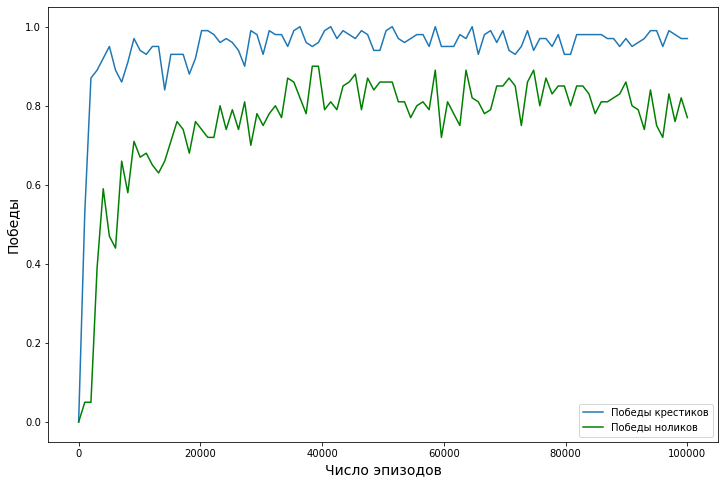

In [12]:
net = DQN(env_3, Network_3)

evaluate_and_plot_wins_dqn(net, n_episodes_train=100_000, n_episodes_eval=100, step=1000)

100%|███████████████████████████████████| 100000/100000 [22:18<00:00, 74.70it/s]


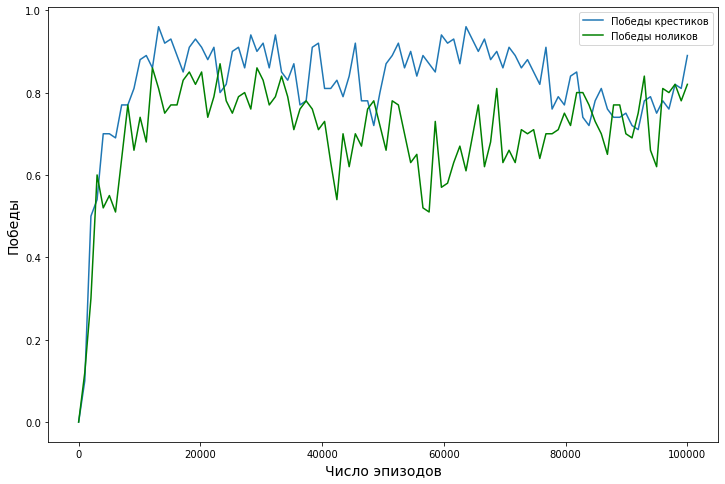

In [13]:
net = DQN(env_4, Network_4)

evaluate_and_plot_wins_dqn(net, n_episodes_train=100_000, n_episodes_eval=100, step=1000)

Видно, что DQN показал лучший результат, чем Q-обучение, на поле 4 на 4.

4. Реализуйте Double DQN и/или Dueling DQN.

In [14]:
class DuelingNetwork_3(Network_3):
    def __init__(self, layer_size=256):
        super().__init__()
        self.l1 = nn.Conv2d(3, layer_size, 3)
        self.l2 = nn.Linear(layer_size, layer_size)
        self.v = nn.Linear(layer_size, 1)
        self.a = nn.Linear(layer_size, 9)

    def forward(self, x):
        x = F.relu(self.l1(x))
        x = torch.flatten(x, 1)
        x = F.relu(self.l2(x))
        v = self.v(x)
        a = self.a(x)
        q = v + (a - a.mean(1, keepdim=True))
        return q
    
class DuelingNetwork_4(Network_4):
    def __init__(self, layer_size=256):
        super().__init__()
        self.l1 = nn.Conv2d(3, layer_size, 3)
        self.l2 = nn.Linear(layer_size * 4, layer_size)
        self.v = nn.Linear(layer_size, 1)
        self.a = nn.Linear(layer_size, 16)

    def forward(self, x):
        x = F.relu(self.l1(x))
        x = torch.flatten(x, 1)
        x = F.relu(self.l2(x))
        v = self.v(x)
        a = self.a(x)
        q = v + (a - a.mean(1, keepdim=True))
        return q

100%|██████████████████████████████████| 100000/100000 [11:45<00:00, 141.81it/s]


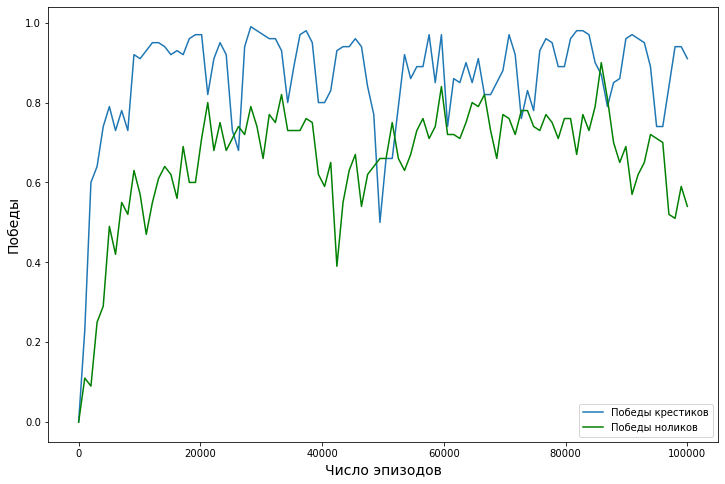

In [15]:
net = DQN(env_3, DuelingNetwork_3)
evaluate_and_plot_wins_dqn(net, n_episodes_train=100_000, n_episodes_eval=100, step=1000)

100%|███████████████████████████████████| 100000/100000 [23:38<00:00, 70.51it/s]


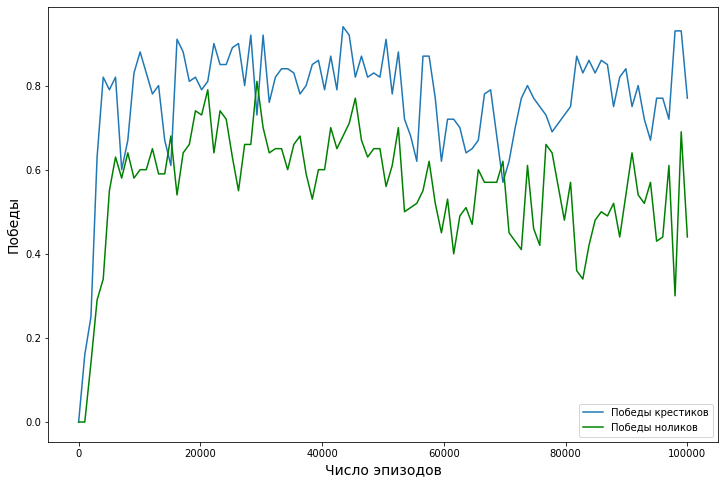

In [16]:
net = DQN(env_4, DuelingNetwork_4)
evaluate_and_plot_wins_dqn(net, n_episodes_train=100_000, n_episodes_eval=100, step=1000)

5. Реализуйте rollouts со случайной стратегией и (опционально) rollouts с неслучайной, но простой стратегией (например, основанной на дополнении нескольких паттернов или на Q-функции, которая у вас получилась в первом пункте).

Реализуем rollout со случайной стратегией

In [25]:
def rollout(env):
    rollout_env = deepcopy(env)
    s, empty_spaces, turn = rollout_env.getState()
    done = False
    while not done:
        i = np.random.randint(len(empty_spaces))
        a = empty_spaces[i]
        (s, empty_spaces, _), r, done, _ = rollout_env.step(a) 
    return - r * turn

def rollout_evaluation(env, empty_spaces, n_rollouts=20, crosses=True):
    i_opt, q_opt = None, -np.inf
    for i in range(len(empty_spaces)):
        next_env = deepcopy(env)
        a = empty_spaces[i]
        _ , r, done, _ = next_env.step(a) 
        if not done:
            q = np.mean([rollout(next_env) for _ in range(n_rollouts)])
        else:
            q = r if crosses else -r
        if q > q_opt:
            i_opt, q_opt = i, q
    return i_opt

def rollout_play(env, n_rollouts=20, crosses=True):
    wins = []
    s, empty_spaces, cur_turn = env.reset()
    done = False
    while not done:
        if (cur_turn == 1 and crosses) or (cur_turn == -1 and not crosses):
            i = rollout_evaluation(env, empty_spaces, n_rollouts, crosses)
        else:
            i = np.random.randint(len(empty_spaces))
        a = empty_spaces[i]
        (s, empty_spaces, cur_turn), r, done, _ = env.step(a) 
    wins.append(r if crosses else -r)
    return wins

def evaluate_rollout_wins(env, n_episodes, n_rollouts=20):
    wins_x, wins_o = [], []
    for i in tqdm(range(n_episodes)):
        win_x = rollout_play(env, n_rollouts)
        win_o = rollout_play(env, n_rollouts, crosses=False)
        wins_x.append(np.mean(win_x))
        wins_o.append(np.mean(win_o))

    print(f"Победы крестиков: {(np.array(wins_x) == 1).mean()}")
    print(f"Победы ноликов: {(np.array(wins_o) == 1).mean()}")


In [26]:
evaluate_rollout_wins(env_3, 1000)

100%|███████████████████████████████████████| 1000/1000 [04:00<00:00,  4.15it/s]

Победы крестиков: 0.985
Победы ноликов: 0.868


In [27]:
evaluate_rollout_wins(env_4, 1000)

100%|███████████████████████████████████████| 1000/1000 [28:07<00:00,  1.69s/it]

Победы крестиков: 0.963
Победы ноликов: 0.879


Видно, что с помощью rollout за 1000 эпизодов уже достигнут хороший результат.